In [1]:
env_USE_GOOGLE_COLAB = False
env_USE_NVIDIA = False
env_CONTENT_PATH = ""
env_TIF_PATH = ""
env_WANT_NGROK = False
env_Latest_RUN_ID = 0
import sys
from settings import load_BatGutsSettings, show_python_version, corr2, get_most_recent_subdirectory, get_most_recent_numeric_subdirectory
from settings import run_mlflow_until_q
show_python_version()

S = load_BatGutsSettings()
env_CONTENT_PATH = S.zContentPath
env_TIF_PATH = S.zTifPath
env_USE_GOOGLE_COLAB = S.useGoogleColab
env_USE_NVIDIA = S.useNvidia
env_MODEL_FILENAME = S.zModelFilename
env_FULL_MODEL_PATH = env_CONTENT_PATH + "/" + env_MODEL_FILENAME

Python version: 3.12.4
Loading settings from /Users/thomasyohe/isr/BatGutsImageClassification2/jupyternb/.env
my_CONTENT_PATH=/Users/thomasyohe/isr/bguts
my_TIF_PATH=/Users/thomasyohe/isr/bguts/tiffs


In [2]:
if env_USE_GOOGLE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import tifffile as tiff

In [4]:
#!pip install pyngrok==4.1.1
from pyngrok import ngrok

In [5]:
import numpy as np
from PIL import Image as im
from PIL import  ImageOps

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.python.keras.utils.data_utils import Sequence
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [7]:
print("TensorFlow version="+str(tf.__version__))

TensorFlow version=2.17.0


In [8]:
#!pip install mlflow

In [9]:
import mlflow

In [10]:
''' 
this cell sets up a clean environment for MLflow tracking:
It removes any existing MLflow runs directory (if it exists).
It creates a fresh directory for new MLflow runs.
It configures MLflow to use this new directory for tracking experiments and runs.
This approach ensures that MLflow starts with a clean slate, which can be useful for avoiding conflicts with 
previous runs or for maintaining a consistent environment across different executions of a machine learning workflow.
'''
zUrl = env_CONTENT_PATH + "/mlruns/"
if os.path.exists(zUrl):
    shutil.rmtree(zUrl)    #r removes the entire directory tree 
    print(f"Deleted directory: {zUrl}")
os.makedirs(zUrl, exist_ok=True)
mlflow.set_tracking_uri(zUrl)   # sets the tracking URI for MLflow to the newly created directory 

Deleted directory: /Users/thomasyohe/isr/bguts/mlruns/


In [11]:
EXPERIMENT_NAME = "Batguts-Insects_vs_plants_Siamese_256"
EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)

In [12]:
def display_image(path):
  baseimage = tiff.imread(path)
  print ('original image shape',baseimage.shape)
  baseimage = np.squeeze(baseimage)

  plt.figure()

  plt.imshow(baseimage)

In [13]:
zBase = env_TIF_PATH 
zDir = zBase + "/LS042_Cormura_brevirostris-LY20_10-insect"
zSubDir = zDir + "/LS042_Cormura_brevirostris-LY20_10-insect-guts-LY20-10A-AB-08"
zImage = zSubDir + "/LS042_Cormura_brevirostris-LY20_10-insect-guts-LY20-10A-AB-08-LY20-10A_ab_08_LS042_Cobr_2021-09-21 15-27-21 (B,Radius8,Smoothing4).tif"
display_image(zImage)

original image shape (8184, 8248, 3)


In [14]:
zBase = env_TIF_PATH + "/DRXXX_Brachyphylla_pumila-LY20_13-nectar"
zDir = zBase + "/DRXXX_Brachyphylla_pumila-LY20_13-nectar-guts-LY20-13A-HE-006"
zImage = zDir + "/DRXXX_Brachyphylla_pumila-LY20_13-nectar-guts-LY20-13A-HE-006-Plane004.tif"

display_image(zImage)

original image shape (5895, 7839, 3)


In [15]:
import seaborn as sns

In [16]:
import cv2

In [17]:
# plt.imshow(image)

In [18]:
import time
import os
import glob

In [19]:
''' 
Standardizes each image in the list:
It subtracts the mean (mean_img)
Then divides by the standard deviation (std_img)
This process centers the pixel values around 0 and scales them to have unit variance.
'''
def standardize_image(img_list):
  mean_img = np.mean(img_list,axis=0)  # calculates the mean value across all images in the list
  std_img = np.std(img_list,axis=0)   # calculates the standard deviation across all images in the list,
  img_list = (img_list - mean_img)/std_img
  return img_list


In [20]:
# def train_imgs(img_list=list(),category=None,one_hot_list=list(),label_list=list()):
#   if len(img_list)==0 and len(one_hot_list)==0 and len(label_list)==0 :
#     img_list=[]
#     label_list=[]
#   else :
#     img_list =img_list
#   for main_path in glob.glob("/content/drive/MyDrive/Bats_mixed_images_RGB_256/"+ str(category)+"/"):
#       paths=glob.glob(os.path.join(main_path,"*.jpeg"))
#   print('{} Images Count: {}'.format(category,len(paths)))
#   for image_path in paths:
#         image = cv2.imread(image_path)
#         img_list.append(image)
#         label_list.append(one_hot_list)
#   return img_list,label_list







In [21]:
''' 
This function loads images from a specific category and create scorresponding image and label lists.
'''
def train_imgs(img_list=list(),category=None,label_list=None):
  if len(img_list)==0 and label_list is  None :
    img_list=[]
  else :
    img_list =img_list
  for main_path in glob.glob( env_CONTENT_PATH + "/images/Bats_mixed_images_RGB_256/"+ str(category)+"/"):
      paths=glob.glob(os.path.join(main_path,"*.jpeg"))
  print('{} Images Count: {}'.format(category,len(paths)))
  for image_path in paths:
        image = cv2.imread(image_path)
        img_list.append(image)
        label_list.append(category)
  return img_list,label_list

In [22]:
#len(plants_list[0:97])

In [23]:
#prepare training data
train_imgs_list = list()
labels_list =list()
# train_imgs_list,labels_list=train_imgs(train_imgs_list,'Blood',labels_list)
train_imgs_list,labels_list=train_imgs(train_imgs_list,'Insects',labels_list)

train_imgs_list,labels_list=train_imgs(train_imgs_list,'Plants',labels_list)


Insects Images Count: 16
Plants Images Count: 30


In [24]:
from sklearn.preprocessing import LabelEncoder

In [25]:
labels_list= LabelEncoder().fit_transform(labels_list)

In [26]:
from collections import Counter

In [27]:
Counter(labels_list)

Counter({1: 30, 0: 16})

In [28]:
#Shuffle the data
import random

temp = list(zip(train_imgs_list, labels_list))
random.shuffle(temp)
train_imgs_list,labels_list = zip(*temp)
train_imgs_list,labels_list = list(train_imgs_list), list(labels_list)

In [29]:
lt = len(train_imgs_list)
print( "The number of items in 'train_imgs_list' is " + str( lt ) )

The number of items in 'train_imgs_list' is 46


In [30]:
ll = len(labels_list)
print("The number of items in the labels_list is " + str( ll ))

The number of items in the labels_list is 46


In [31]:
'''
This code performs two important preprocessing steps on a list of images, typically in preparation for training a 
machine learning model, particularly a neural network.  

First it converts train_imgs_list to a NumPy array with data type float32.
Then it Divides the array by 255.0.
This normalizes the pixel values of the images to a range between 0 and 1.
Normalization is important because:
  It helps achieve faster convergence during model training.
  It ensures all features (pixel values) are on a similar scale, which is crucial for many machine learning algorithms.
  
Then it calls the standardize_image function on the normalized image array.
Standardization typically involves subtracting the mean and dividing by the standard deviation.
This centers the data around zero and scales it to have unit variance.
Benefits of standardization include:
  Making training less sensitive to the scale of features.
  Improving the numerical stability of some machine learning algorithms.
'''
X = np.array(train_imgs_list,np.float32)/255.0
X = standardize_image(X)

In [32]:
''' 
retrieves the shape of the array. The shape of an array is a tuple representing the dimensions of the array.
Here's what X.shape does:
Retrieve Dimensions:
It returns a tuple where each element of the tuple represents the size of the array along a particular dimension.
For example, if X is a 2D array (matrix) with 3 rows and 4 columns, X.shape would return (3, 4).
'''
X.shape

(46, 256, 256, 3)

In [33]:
lX = len(X)
print("The number of items in 'X' is " + str(lX) )

The number of items in 'X' is 46


In [34]:
''' 
This cell converts a Python list called labels_list into a NumPy array

Converting labels_list to a NumPy array makes it more efficient and provides 
access to a wide range of functionalities for numerical and data manipulation tasks. This step is 
often a part of data preprocessing in machine learning workflows.
'''
labels_list = np.array(labels_list)

In [35]:
from imblearn.over_sampling import SMOTE

In [36]:
# from imblearn.over_sampling import ADASYN
# adasyn = ADASYN(random_state = 101,sampling_strategy='minority')

In [37]:
# X_re = X.reshape((X.shape[0],256*256*3))

In [38]:
# X_re.shape

In [39]:
# oversample = SMOTE()
# X_smote, labels_list_smote = adasyn.fit_resample(X_re, labels_list)

In [40]:
# Counter(labels_list_smote)

In [41]:
# len(labels_list_smote)

In [42]:
# X_smote.shape

In [43]:
# Xsmote=X_smote.reshape(X_smote.shape[0],256,256,3)

In [44]:
# Xsmote.shape

In [45]:
''' 
This function defines and uses a function one_hot_labels to convert a list of categorical labels into 
one-hot encoded vectors. 

Key Points:
This function is designed for binary classification (num_classes = 2), but 
could be adapted for multi-class problems.

It assumes that to_categorical is imported (likely from keras.utils).

The original labels are overwritten with their one-hot encoded versions.
One-hot encoding is useful for many machine learning models, especially neural networks, as 
it provides a format that can be easily processed by the model.
This preprocessing step is common in preparing categorical data for machine learning models, e
specially in classification tasks.



'''
num_classes = 2
def one_hot_labels(img_list,classes):


  label_numeric = {k:v for v,k in enumerate(set(img_list))}
  target_values = [label_numeric[k] for k in img_list]
  target_values = np.array(target_values)
  target_values = to_categorical(target_values,num_classes=num_classes)
  return target_values

labels_list = one_hot_labels(labels_list,num_classes)

In [46]:
# labels_list = np.array(labels_list)

In [47]:
# len(labels_list_smote)

In [48]:

''' 
This cell is using the train_test_split function from scikit-learn to split the 
dataset into training, validation, and test sets. 
'''
# Splitting the data into train and validation set
from sklearn.model_selection import train_test_split
print("Shape of X:", X.shape)
print("Shape of labels_list:", labels_list.shape)
X_train,x_test,Y_train,y_test = train_test_split(X,labels_list ,test_size=0.1,random_state=1,stratify=labels_list)
x_train,x_valid,y_train,y_valid = train_test_split(X_train,Y_train,test_size=0.1,random_state=1,stratify=Y_train)

Shape of X: (46, 256, 256, 3)
Shape of labels_list: (46, 2)


In [49]:
# Data Augumentation
train_datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2],# brightness
        fill_mode='nearest')


In [50]:
train_datagen.fit(X)

In [51]:
#!pip install keras-unet

In [52]:
# base_model = ResNet50(include_top=False,weights='imagenet',input_shape=(256,256,3))

In [53]:
from keras_unet.models import vanilla_unet

base_model  = vanilla_unet(input_shape=(256, 256, 3))

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [54]:
from tensorflow.keras.layers import BatchNormalization
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256,activation='relu'))
add_model.add(Dropout(0.3))
add_model.add(Dense(256,activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(2,activation='softmax'))
model = Model(inputs=base_model.input,outputs = add_model(base_model.output))
model.summary()

/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 254, 254,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 252, 252,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 126, 126,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 124, 124,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 122, 122,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 61, 61,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 59, 59,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 57, 57,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 26, 26,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 24, 24,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 12, 12,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12, 12,    │          0 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 10, 10,    │  4,719,616 │ dropout[0][0]     │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]  

 Total params: 32,282,051 (123.15 MB)

 Trainable params: 32,282,051 (123.15 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Compiling Model
optimizer = Adam(learning_rate=1e-5)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [56]:
# Defining callback Methods
n_epoch = 60

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,
                             verbose=1, mode='auto')

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


Number of unique classes in y_train: 2
Number of unique classes in y_valid: 2
Number of unique classes in y_test: 2
Epoch 1/60


/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3271 - loss: 0.8950 - val_accuracy: 0.6000 - val_loss: 0.6360 - learning_rate: 1.0000e-05
Epoch 2/60
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3750 - loss: 0.9355

/opt/anaconda3/envs/BatGuts4/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.3750 - loss: 0.9355 - val_accuracy: 0.6000 - val_loss: 0.6363 - learning_rate: 1.0000e-05
Epoch 3/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5410 - loss: 0.7696 - val_accuracy: 0.6000 - val_loss: 0.6344 - learning_rate: 1.0000e-05
Epoch 4/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.6250 - loss: 0.6512 - val_accuracy: 0.6000 - val_loss: 0.6335 - learning_rate: 1.0000e-05
Epoch 5/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5452 - loss: 0.6652 - val_accuracy: 0.6000 - val_loss: 0.6282 - learning_rate: 1.0000e-05
Epoch 6/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.7500 - loss: 0.4690 - val_accuracy: 0.6000 - val_loss: 0.6282 - learning_rate: 1.0000e-05
Epoch 7/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5986 - loss: 0.6654 - val_accuracy: 0.6000 - val_loss: 0.6317 - learning_rate: 1.0000e-05
Epoch 8/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.5000 - loss: 0.7480 - val_accurac

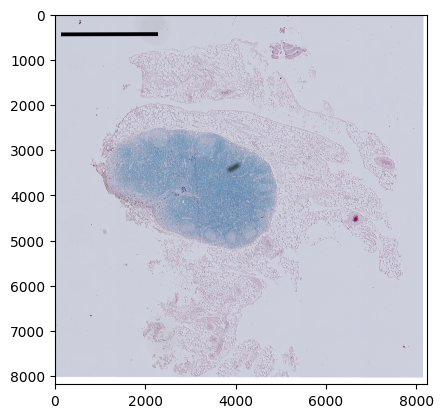

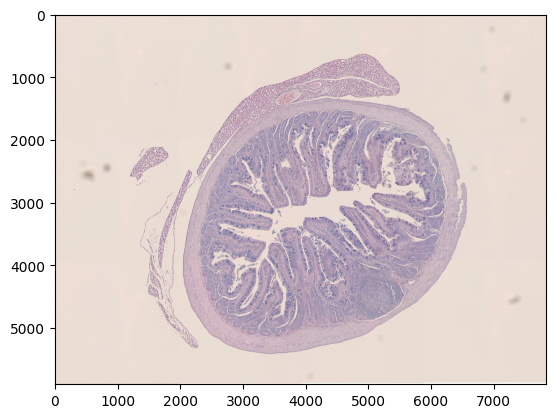

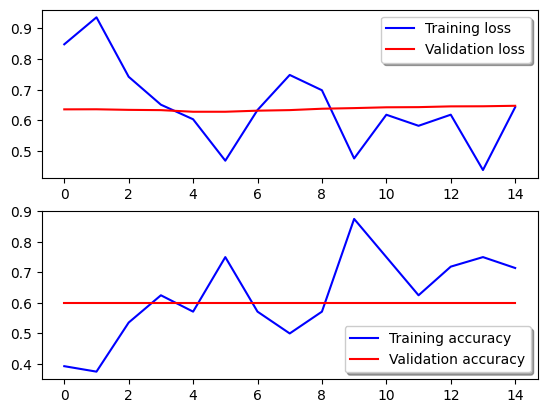

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
              precision    recall  f1-score   support

     Insects       0.00      0.00      0.00         2
      Plants       0.60      1.00      0.75         3

   micro avg       0.60      0.60      0.60         5
   macro avg       0.30      0.50      0.38         5
weighted avg       0.36      0.60      0.45         5
 samples avg       0.60      0.60      0.60         5

MLflow run ID: 901e7276771448bbb0d1ffcca36771b0


/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60


/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8583 - loss: 0.5259 - val_accuracy: 0.6000 - val_loss: 0.6283 - learning_rate: 4.0000e-07
Epoch 2/60
1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.8750 - loss: 0.5786

/opt/anaconda3/envs/BatGuts4/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - accuracy: 0.8750 - loss: 0.5786 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 4.0000e-07
Epoch 3/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.6667 - loss: 0.5731 - val_accuracy: 0.6000 - val_loss: 0.6285 - learning_rate: 4.0000e-07
Epoch 4/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - accuracy: 0.7500 - loss: 0.6578 - val_accuracy: 0.6000 - val_loss: 0.6286 - learning_rate: 4.0000e-07
Epoch 5/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6958 - loss: 0.6309 - val_accuracy: 0.6000 - val_loss: 0.6287 - learning_rate: 4.0000e-07
Epoch 6/60
1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.6875 - loss: 0.5949
Epoch 6: ReduceLROnPlateau reducing learning rate to 8.00000009348878e-08.
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step - accuracy: 0.6875 - loss: 0.5949 - val_accuracy: 0.6000 - val_loss: 0.6287 - learning_rate: 4.0000e-07
Epoch 7/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6625 - loss: 0.6338 - val_accuracy: 0.600

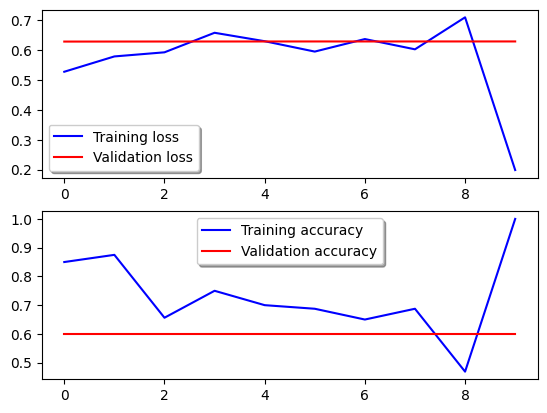

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
              precision    recall  f1-score   support

     Insects       0.00      0.00      0.00         2
      Plants       0.60      1.00      0.75         3

   micro avg       0.60      0.60      0.60         5
   macro avg       0.30      0.50      0.38         5
weighted avg       0.36      0.60      0.45         5
 samples avg       0.60      0.60      0.60         5

MLflow run ID: 3194ecc0414c40398d950db0315ac2f0


/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60


/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.7500 - loss: 0.6086 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 8.0000e-08
Epoch 2/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2500 - loss: 0.7919 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 8.0000e-08
Epoch 3/60


/opt/anaconda3/envs/BatGuts4/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 8.0000e-08
Epoch 4/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5625 - loss: 0.6822 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 8.0000e-08
Epoch 5/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.8161 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 8.0000e-08
Epoch 6/60

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.5999999902760466e-08.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 8.0000e-08
Epoch 7/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6875 - loss: 0.5972 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 1.6000e-08
Epoch 8/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 1.0076 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 1.6000e-08
E

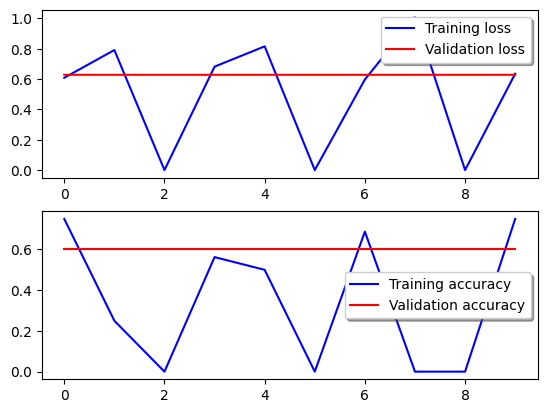

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
              precision    recall  f1-score   support

     Insects       0.00      0.00      0.00         2
      Plants       0.60      1.00      0.75         3

   micro avg       0.60      0.60      0.60         5
   macro avg       0.30      0.50      0.38         5
weighted avg       0.36      0.60      0.45         5
 samples avg       0.60      0.60      0.60         5

MLflow run ID: e6039681507649c5a6f7362b83f77d68


/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60


/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5556 - loss: 0.6618 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 1.6000e-08
Epoch 2/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6944 - loss: 0.5847 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 1.6000e-08
Epoch 3/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6667 - loss: 0.6276 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 1.6000e-08
Epoch 4/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6389 - loss: 0.6973 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 1.6000e-08
Epoch 5/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6111 - loss: 0.6395 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 1.6000e-08
Epoch 6/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6111 - loss: 0.7331
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.1999999094978194e-09.
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6111 - loss: 0.7331 - val_accuracy: 0.6000 - val

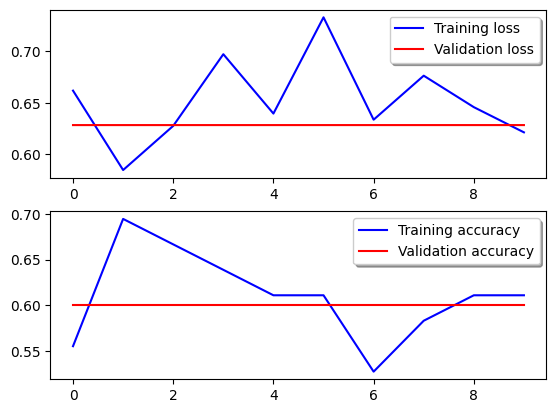

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
              precision    recall  f1-score   support

     Insects       0.00      0.00      0.00         2
      Plants       0.60      1.00      0.75         3

   micro avg       0.60      0.60      0.60         5
   macro avg       0.30      0.50      0.38         5
weighted avg       0.36      0.60      0.45         5
 samples avg       0.60      0.60      0.60         5

MLflow run ID: f9638255b9714223826809852eb2eb78


/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60


/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.4722 - loss: 0.7962 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 3.2000e-09
Epoch 2/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6389 - loss: 0.6773 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 3.2000e-09
Epoch 3/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.4722 - loss: 0.7219 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 3.2000e-09
Epoch 4/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5833 - loss: 0.5976 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 3.2000e-09
Epoch 5/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5833 - loss: 0.6822 - val_accuracy: 0.6000 - val_loss: 0.6284 - learning_rate: 3.2000e-09
Epoch 6/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6111 - loss: 0.6145
Epoch 6: ReduceLROnPlateau reducing learning rate to 6.399999641359955e-10.
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6111 - loss: 0.6145 - val_accuracy: 0.6000 - val_

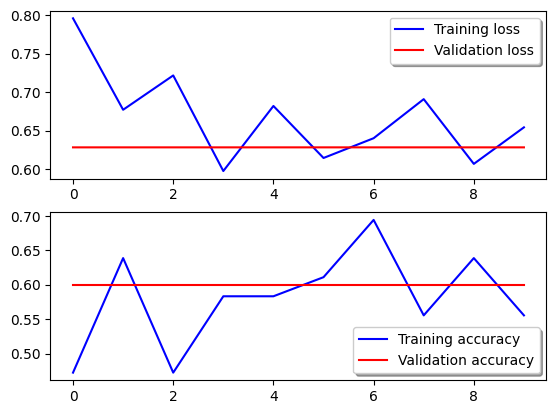

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
              precision    recall  f1-score   support

     Insects       0.00      0.00      0.00         2
      Plants       0.60      1.00      0.75         3

   micro avg       0.60      0.60      0.60         5
   macro avg       0.30      0.50      0.38         5
weighted avg       0.36      0.60      0.45         5
 samples avg       0.60      0.60      0.60         5

MLflow run ID: c7866838118341a4a0f275dfd8947a4f


/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [58]:
''' 
This cell This code performs a series of tasks to train a machine learning model using different batch 
sizes, evaluate its performance, plot the results, 
make predictions, and log the results using MLflow. 
'''
print("Number of unique classes in y_train:", len(np.unique(y_train)))
print("Number of unique classes in y_valid:", len(np.unique(y_valid)))
print("Number of unique classes in y_test:", len(np.unique(y_test)))
for idx, batch_size in enumerate([8, 16, 32, 64, 128]):
    history = model.fit(
        train_datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=n_epoch,
        callbacks=[reduce_lr, early_stop],
        validation_data=(x_valid, y_valid),
        steps_per_epoch=len(x_train) // batch_size  # Adjusted to match the batch size
    )
    
    # Plotting the results on Graph
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
    ax[0].legend(loc='best', shadow=True)
    
    ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
    ax[1].legend(loc='best', shadow=True)
    
    plt.show()  # Ensure the plot displays within each iteration

    # Predictions
    predictions_model = model.predict(x_test)
    predictions_model_max = np.argmax(predictions_model, axis=1)
    num_classes = len(np.unique(y_test))  # Ensure correct number of classes
    predictions_onehot = to_categorical(predictions_model_max, num_classes=num_classes)
    accuracy = accuracy_score(y_test, predictions_onehot)
    
    print(classification_report(y_test, predictions_onehot, target_names=['Insects', 'Plants']))

    # Start MLflow
    RUN_NAME = f"run_{idx}"
    with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=RUN_NAME) as run:
        # Retrieve run id
        RUN_ID = run.info.run_id
        env_Latest_RUN_ID = RUN_ID
        print(f"MLflow run ID: {RUN_ID}")
        # Track parameters
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("epochs", 60)
        mlflow.log_param("image_size", 256)

        # Track model
        mlflow.sklearn.log_model(model, "Bat_guts_IVP_classifier")

        # Track confusion matrix results
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric('Weighted Precision', precision_score(y_test, predictions_onehot, average='weighted'))
        mlflow.log_metric('Weighted Recall', recall_score(y_test, predictions_onehot, average='weighted'))
        mlflow.log_metric('Weighted F1-score', f1_score(y_test, predictions_onehot, average='weighted'))




In [59]:
if env_WANT_NGROK:
    ngrok.kill()

    # Setting the authtoken (optional)
    # Get your authtoken from https://dashboard.ngrok.com/auth
    NGROK_AUTH_TOKEN = "2AVGMje37gfu1yzYm2UJWam40Mm_dmYa8aw82QJvUCwSCETo"
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)

    # Open an HTTPs tunnel on port 5000 for http://localhost:5000
    ngrok_tunnel = ngrok.connect(port="5000", proto="http", options={"bind_tls": True})
    print("MLflow Tracking UI:", ngrok_tunnel)

In [60]:
mlrun_path = env_CONTENT_PATH + "/mlruns"
print( "Let it run for at most two minutes before hitting 'q'")
run_mlflow_until_q( mlrun_path )

Let it run for at most two minutes before hitting 'q'
MLflow UI started. Access it at http://127.0.0.1:5000
Enter 'q' up at the top of the screen to terminate
MLflow UI has been shut down.


In [61]:
# Plotting the results on Graph
#fig, ax = plt.subplots(2,1)
#ax[0].plot(history.history['loss'], color='b', label="Training loss")
#ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
#legend = ax[0].legend(loc='best', shadow=True)

#ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
#ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
#legend = ax[1].legend(loc='best', shadow=True)

In [62]:
# Predictions on testing data created from training data
predictions_model = model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


In [63]:
predictions_model_max = np.argmax(predictions_model,axis=1)
predictions_onehot = to_categorical(predictions_model_max)

In [64]:
y_test

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [65]:
predictions_onehot

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [66]:
# Classification Report
print(classification_report(y_test,predictions_onehot,target_names=['Insects','Plants']))

              precision    recall  f1-score   support

     Insects       0.00      0.00      0.00         2
      Plants       0.60      1.00      0.75         3

   micro avg       0.60      0.60      0.60         5
   macro avg       0.30      0.50      0.38         5
weighted avg       0.36      0.60      0.45         5
 samples avg       0.60      0.60      0.60         5



/opt/anaconda3/envs/BatGuts4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [67]:
from keras.applications.xception import preprocess_input,decode_predictions

In [68]:
import keras

In [69]:
print(keras.__version__)

3.4.1


In [70]:
from tensorflow.keras.preprocessing import image

In [71]:
def classify(img_path,model):
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)

    prediction = model.predict(img_preprocessed)
    print(prediction)
    prediction_max = [int(i > .5) for i in prediction[0]]

    if 1 in prediction_max and sum(prediction_max)==1:
      # if prediction_max.index(1) ==0:
      #   return 'Bat eats Blood'
      if prediction_max.index(1) ==0:
        return 'This Bat eat Insects'
      if prediction_max.index(1) ==1:
        return 'This Bat eat Plants'

    else:
      return prediction_max

In [72]:

logged_model = "runs:/" + str( env_Latest_RUN_ID) + "/Bat_guts_IVP_classifier"

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [73]:
import pickle
import numpy as np

In [74]:
zBaseDir = env_CONTENT_PATH + "/mlruns/"
zSubDir = get_most_recent_numeric_subdirectory( zBaseDir )
print( "zSubDir="+zSubDir)
zSubSubDir = get_most_recent_numeric_subdirectory( zSubDir )
loaded_model = pickle.load(open( zSubSubDir + "/artifacts/Bat_guts_IVP_classifier/model.pkl", 'rb'))

zSubDir=/Users/thomasyohe/isr/bguts/mlruns/961520532861330104


In [75]:
zDir = env_CONTENT_PATH + "/images/Bats_mixed_images_RGB_256/Plants"
zFilePath = zDir + "/DRXXX_Brachyphylla_pumila-LY20_13-nectar-guts-LY20-13A-HE-006-Plane004__blue.jpeg"
classify( zFilePath,loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
[[0.3184169 0.6815831]]


'This Bat eat Plants'

In [76]:
zDir = env_CONTENT_PATH + "/images/Bats_mixed_images_RGB_256/Plants"
zFilePath = zDir + "/DRXXX_Brachyphylla_pumila-LY20_13-nectar-guts-LY20-13A-HE-006-Plane007__blue.jpeg"
classify( zFilePath,loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
[[0.3161996  0.68380046]]


'This Bat eat Plants'

In [77]:
zDir = env_CONTENT_PATH + "/images/Bats_mixed_images_RGB_256/Plants/"
paths = glob.glob(os.path.join( zDir,"*.jpeg"))

In [78]:
import pickle

In [79]:
#loaded_model = pickle.load(open('/Users/macstudio/isr/mlruns/935355134370886693/0be5d555ffe34839834bcb4e0ed203d2/artifacts/Bat_guts_IVP_classifier/model.pkl', 'rb'))

In [80]:
len(paths)

30

In [81]:
k=0
for path in paths:

  if 'Bat eats Insects' == classify(path,loaded_model):
    print('here')
    k=k+1
  else:
    print(path)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
[[0.32868296 0.67131704]]
/Users/thomasyohe/isr/bguts/images/Bats_mixed_images_RGB_256/Plants/DRXXX_Brachyphylla_pumila-LY20_13-nectar-guts-LY20-13A-HE-006-Plane005__red.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
[[0.31925046 0.68074954]]
/Users/thomasyohe/isr/bguts/images/Bats_mixed_images_RGB_256/Plants/DRXXX_Brachyphylla_pumila-LY20_13-nectar-guts-LY20-13A-HE-006-Plane005__blue.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
[[0.31456834 0.6854317 ]]
/Users/thomasyohe/isr/bguts/images/Bats_mixed_images_RGB_256/Plants/DRXXX_Brachyphylla_pumila-LY20_13-nectar-guts-LY20-13A-HE-006-Plane008__green.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
[[0.32295552 0.67704445]]
/Users/thomasyohe/isr/bguts/images/Bats_mixed_images_RGB_256/Plants/DRXXX_Brachyphylla_pumila-LY20_13-nectar-guts-LY20-13A-HE-006-Plane008__red.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
[[0.31828496 0.68171513]]
/Users/thomasyohe/isr/bguts/images/Bats_mixed_images_RGB_256/Plants/DRXXX_Brachy

In [82]:
k,len(paths)

(0, 30)

In [83]:
j=0
for path in paths:

  if 'Bat eats Plants' == classify(path,loaded_model):
    print('here')
    j=j+1
  else:
    print(path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
[[0.32868296 0.67131704]]
/Users/thomasyohe/isr/bguts/images/Bats_mixed_images_RGB_256/Plants/DRXXX_Brachyphylla_pumila-LY20_13-nectar-guts-LY20-13A-HE-006-Plane005__red.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
[[0.31925046 0.68074954]]
/Users/thomasyohe/isr/bguts/images/Bats_mixed_images_RGB_256/Plants/DRXXX_Brachyphylla_pumila-LY20_13-nectar-guts-LY20-13A-HE-006-Plane005__blue.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
[[0.31456834 0.6854317 ]]
/Users/thomasyohe/isr/bguts/images/Bats_mixed_images_RGB_256/Plants/DRXXX_Brachyphylla_pumila-LY20_13-nectar-guts-LY20-13A-HE-006-Plane008__green.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
[[0.32295552 0.67704445]]
/Users/thomasyohe/isr/bguts/images/Bats_mixed_images_RGB_256/Plants/DRXXX_Brachyphylla_pumila-LY20_13-nectar-guts-LY20-13A-HE-006-Plane008__red.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
[[0.31828496 0.68171513]]
/Users/thomasyohe/isr/bguts/images/Bats_mixed_images_RGB_256/Plants/DRXXX_Brachyp

In [84]:
j,len(paths)

(0, 30)

In [85]:
#check versions
import flask
print("flask version="+flask.__version__)
print("numpy version="+np.__version__)
show_python_version()
import mlflow
print("mlflow version="+mlflow.__version__)

flask version=3.0.3
numpy version=1.26.4
Python version: 3.12.4
mlflow version=2.14.3


/var/folders/fw/j27fkmm12hz_82xl8gd1v3tc0000gn/T/ipykernel_55602/3504533110.py:3: DeprecationWarning: The '__version__' attribute is deprecated and will be removed in Flask 3.1. Use feature detection or 'importlib.metadata.version("flask")' instead.
  print("flask version="+flask.__version__)
